In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import os
import sys
sys.path.append("..")

import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange

from dots.training import train_and_return_losses
from dots.models import MLP
from dots.dots import *

In [3]:
model = MLP(1, 1, hidden = 4, hidden_size = 12)
N = 200
N_test = 50
x = rearrange(t.linspace(0, 8, 200), "x -> x 1")
y = t.sin(x)

t.manual_seed(42)
dataset = tdata.TensorDataset(x, y)
train_dataset, test_dataset = tdata.random_split(dataset, lengths = [N - N_test, N_test])
train_dataloader = tdata.DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = tdata.DataLoader(test_dataset, batch_size=10, shuffle=True)

In [4]:
train_losses, test_losses = np.array([]), np.array([])
train_xs, test_xs = np.array([]), np.array([])

In [5]:
(add_train_xs, add_train_losses), (add_test_xs, add_test_losses) = train_and_return_losses(
    model,
    t.optim.Adam(model.parameters(), lr=1e-4),
    t.nn.MSELoss(),
    train_dataloader,
    test_dataloader,
    epochs=3000
)

train_losses = np.concatenate([train_losses, add_train_losses])
test_losses = np.concatenate([test_losses, add_test_losses])
current = train_xs.shape[0]
train_xs = np.concatenate([train_xs, add_train_xs + current])
test_xs = np.concatenate([test_xs, add_test_xs + current])

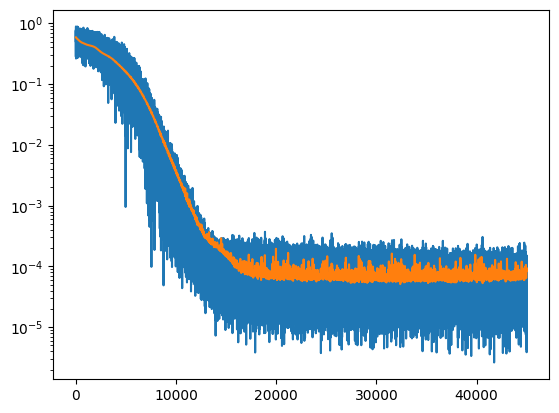

In [6]:
plt.plot(train_xs, train_losses)
plt.plot(test_xs, test_losses)
plt.yscale("log")

In [7]:
x = t.linspace(-2, 10, 1000)
model_outs = model(x.unsqueeze(-1)).detach()

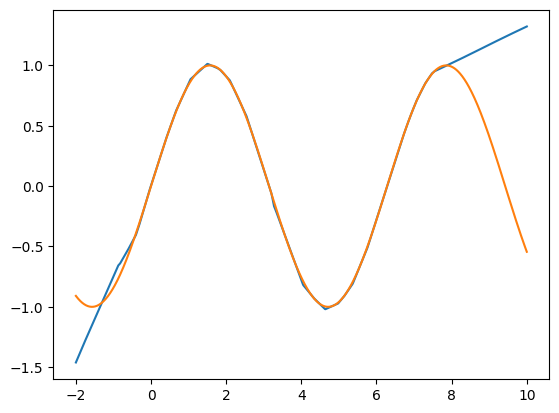

In [8]:
plt.plot(x, model_outs)
plt.plot(x, t.sin(x))


In [43]:
x = t.linspace(0, 4, 1000).unsqueeze(dim=-1)
model.count_params()

505

In [44]:
model.singular_value_rank(x)

tensor(5.2907)

In [45]:
model.jacobian_matrix_rank(x)

tensor(25)

In [47]:
t.linalg.svd(model.matrix_jacobian(x)).S.shape

torch.Size([505])

In [49]:
t.exp(entropy(t.linalg.svd(matrix_jacobian(model, x)).S))

tensor(5.2907)

In [50]:
model.singular_value_rank(x)

tensor(5.2907)